***
In this notebook i will be demonstarting Latent Dirichlet Allocation(LDA) for topic modelling. I will be using the Amazon fine food reviews dataset from Kaggle(https://www.kaggle.com/snap/amazon-fine-food-reviews) for performing LDA based topic modelling
I will be using the gensim package for LDA topic modelling and pyLDAvis for visualization of LDA topic model
***

In [3]:
import pandas as pd
import numpy as np

import re
import string

import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

import sys         
sys.path.append('/home/pranisaa/working_dir/Text-Summarization')
from config import *
import pandas as pd
from datasets import load_dataset
from dataset import Dataset
from transformers import T5Tokenizer, BartTokenizer
pd.set_option('display.max_colwidth', None)
import pickle

### Load dataset

In [4]:
# Load dataset
data = 'xsum'

if data == 'cnn_dailymail':
    dataset = load_dataset(data, '3.0.0')
    source_text = "article"
    target_text = "highlights"
elif data == "xsum":
    dataset = load_dataset(data)
    source_text = "document"
    target_text = "summary"
else:
    raise ValueError("Undefined dataset")

Using custom data configuration default
Reusing dataset xsum (/home/pranisaa/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

### Get dataset

In [6]:
pickle_in = open("val_len_q1_max512.pickle","rb")
example_dict = pickle.load(pickle_in)
q1_id = example_dict['ids']

pickle_in = open("val_len_q3_max512.pickle","rb")
example_dict = pickle.load(pickle_in)
q3_id = example_dict['ids']

In [7]:
df_data = {'id': dataset['validation']['id'], 'document': dataset['validation']['document']}

In [8]:
type(df_data['id'][0])
type(q1_id[0])

int

In [9]:
val_doc_q1 = {'ids': [], 'document': []}
for i, idx in enumerate(df_data['id']):
    if int(idx) in q1_id:
        val_doc_q1['ids'].append(idx)
        val_doc_q1['document'].append(df_data['document'][i])
        
val_doc_q3 = {'ids': [], 'document': []}
for i, idx in enumerate(df_data['id']):
    if int(idx) in q3_id:
        val_doc_q3['ids'].append(idx)
        val_doc_q3['document'].append(df_data['document'][i])

In [11]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()

In [12]:
import nltk
nltk.download('stopwords') # run this one time

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pranisaa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
type(val_doc_q1['document'])

list

In [14]:
val_q1 = pd.DataFrame.from_dict(val_doc_q1)

In [16]:
# review_data.dropna(axis = 0, how ='any',inplace=True) 
val_q1['document'] = val_q1['document'].apply(clean_text)
val_q1['Num_words_text'] = val_q1['document'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
# print(val_q1['Score'].value_counts())
print(len(val_q1))
print('-------------------------')
# max_review_data_sentence_length  = val_q1['Num_words_text'].max()

# mask = (val_q1['Num_words_text'] < 100) & (val_q1['Num_words_text'] >=20)
# df_short_reviews = val_q1[mask]
# df_sampled = df_short_reviews.apply(lambda x: x.sample(n=20000)).reset_index(drop = True)

# print('No of Short reviews')
# print(len(df_short_reviews))



#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()


-------Dataset --------
100
-------------------------


***
Let us pre-process the data
***

In [17]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the text
val_q1['document']=val_q1['document'].apply(remove_stopwords)



In [18]:
# python3 -m spacy download en_core_web_sm
# !python3 -m spacy download en_core_web_sm

In [19]:
# nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
import en_core_web_sm
nlp = en_core_web_sm.load()

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [20]:
 
text_list=val_q1['document'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

whiffin joined club analyst progressing roles head analysis assistant coach exiles confirm coaching setup next season relegated championship rugby department review began last month included head coach coventry assistant coaches clark laidlaw grant doorey
['club', 'analyst', 'role', 'analysis', 'assistant', 'coach', 'exile', 'coaching', 'setup', 'next', 'season', 'championship', 'rugby', 'department', 'review', 'last', 'month', 'head', 'coach', 'coventry', 'assistant', 'coach', 'clark', 'laidlaw']


***
Create vocabulary dictionary and document term matrix
***

In [21]:
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

In [22]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=5, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [23]:
lda_model.print_topics()

[(0,
  '0.010*"share" + 0.009*"bank" + 0.008*"point" + 0.007*"year" + 0.007*"interest" + 0.005*"market" + 0.005*"plan" + 0.005*"public" + 0.004*"sale" + 0.004*"loan"'),
 (1,
  '0.010*"station" + 0.007*"year" + 0.006*"part" + 0.006*"passenger" + 0.005*"staff" + 0.005*"tour" + 0.004*"service" + 0.004*"court" + 0.004*"plan" + 0.004*"place"'),
 (2,
  '0.006*"people" + 0.006*"high" + 0.005*"work" + 0.005*"duffy" + 0.005*"year" + 0.004*"business" + 0.004*"loss" + 0.004*"licence" + 0.004*"coach" + 0.004*"project"'),
 (3,
  '0.009*"first" + 0.008*"last" + 0.007*"police" + 0.007*"year" + 0.007*"club" + 0.005*"good" + 0.005*"season" + 0.005*"time" + 0.004*"investigation" + 0.004*"second"'),
 (4,
  '0.020*"year" + 0.006*"film" + 0.006*"people" + 0.006*"state" + 0.006*"student" + 0.006*"virus" + 0.006*"coin" + 0.005*"good" + 0.005*"last" + 0.004*"medium"')]

In [24]:
# Visualize the topics
#https://github.com/bmabey/pyLDAvis
#https://speakerdeck.com/bmabey/visualizing-topic-models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

/home/pranisaa/thesis/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.066398 -0.054633       1        1  24.617391
4     -0.109795 -0.003317       2        1  21.634608
1      0.095143 -0.095199       3        1  21.339710
2      0.058891  0.045524       4        1  20.394899
0      0.022159  0.107624       5        1  12.013392, topic_info=         Term       Freq      Total Category  logprob  loglift
233   station  10.000000  10.000000  Default  30.0000  30.0000
565     share  11.000000  11.000000  Default  29.0000  29.0000
125      bank   9.000000   9.000000  Default  28.0000  28.0000
826  interest   6.000000   6.000000  Default  27.0000  27.0000
698     virus   6.000000   6.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
169       big   1.864351   6.033080   Topic5  -5.7574   0.9448
105    people   2.446396  22.278679   Topic5  -5.4857  -0.0899
240      area   1.865323   6.062599   Topic5  -5.7569   0.9404
129   company   1.864490  11.768949   Topic5  -5.7573   0.2767
108  proposal   1.864363   7.382593   Topic5  -5.7574   0.7429

[317 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
659       2  0.945154       20th
2065      5  0.539635      469bn
279       2  0.529794       able
279       3  0.353196       able
279       4  0.176598       able
...     ...       ...        ...
121       2  0.454129       year
121       3  0.151376       year
121       4  0.108126       year
121       5  0.086501       year
814       4  0.954695  yorkshire

[526 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 3, 1])

In [25]:

print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -6.895251485820896

Coherence Score:  0.373913358047572


***
Method to find optimal number of topics
Code from:https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore
***

In [26]:


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)

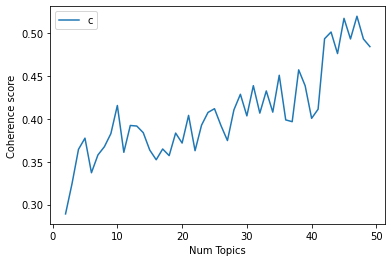

In [28]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores


In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.289
Num Topics = 3  has Coherence Value of 0.3243
Num Topics = 4  has Coherence Value of 0.3644
Num Topics = 5  has Coherence Value of 0.3775
Num Topics = 6  has Coherence Value of 0.3371
Num Topics = 7  has Coherence Value of 0.3579
Num Topics = 8  has Coherence Value of 0.3675
Num Topics = 9  has Coherence Value of 0.3828
Num Topics = 10  has Coherence Value of 0.4156
Num Topics = 11  has Coherence Value of 0.361
Num Topics = 12  has Coherence Value of 0.3923
Num Topics = 13  has Coherence Value of 0.3917
Num Topics = 14  has Coherence Value of 0.3839
Num Topics = 15  has Coherence Value of 0.3636
Num Topics = 16  has Coherence Value of 0.3523
Num Topics = 17  has Coherence Value of 0.3648
Num Topics = 18  has Coherence Value of 0.3571
Num Topics = 19  has Coherence Value of 0.3834
Num Topics = 20  has Coherence Value of 0.3718
Num Topics = 21  has Coherence Value of 0.4041
Num Topics = 22  has Coherence Value of 0.3629
Num Topics = 23  has Co

In [30]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.007*"bank" + 0.007*"woman" + 0.006*"year" + 0.005*"last" + 0.005*"charge" + 0.005*"interest" + 0.005*"public" + 0.004*"standard" + 0.004*"share" + 0.004*"point"'),
 (1,
  '0.010*"year" + 0.008*"club" + 0.007*"people" + 0.006*"film" + 0.006*"worker" + 0.005*"detainee" + 0.005*"good" + 0.005*"fire" + 0.004*"country" + 0.004*"decision"'),
 (2,
  '0.009*"first" + 0.008*"police" + 0.006*"year" + 0.006*"death" + 0.006*"coin" + 0.005*"protester" + 0.005*"last" + 0.004*"space" + 0.004*"point" + 0.004*"trial"'),
 (3,
  '0.008*"year" + 0.008*"student" + 0.008*"m" + 0.008*"station" + 0.007*"week" + 0.007*"school" + 0.006*"site" + 0.006*"last" + 0.005*"park" + 0.005*"gchq"'),
 (4,
  '0.009*"good" + 0.008*"year" + 0.006*"share" + 0.005*"time" + 0.005*"point" + 0.005*"people" + 0.005*"yorkshire" + 0.005*"industry" + 0.004*"part" + 0.004*"possible"'),
 (5,
  '0.008*"school" + 0.007*"year" + 0.007*"plan" + 0.007*"sewer" + 0.007*"passenger" + 0.007*"scottish" + 0.006*"union" + 0.006*"water" +

In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, doc_term_matrix, dictionary)
vis

/home/pranisaa/thesis/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.074028  0.057053       1        1  15.030622
6      0.016950  0.060786       2        1  14.831300
7     -0.137961  0.003653       3        1  12.858957
5      0.015955 -0.094120       4        1  10.809520
8      0.014319  0.008682       5        1  10.377205
1     -0.012577  0.019160       6        1   9.719034
3      0.028980 -0.076690       7        1   9.652271
0      0.024459 -0.008028       8        1   9.110619
2     -0.024153  0.029505       9        1   7.610471, topic_info=        Term       Freq      Total Category  logprob  loglift
268   school  10.000000  10.000000  Default  30.0000  30.0000
49      club  13.000000  13.000000  Default  29.0000  29.0000
698    virus   6.000000   6.000000  Default  28.0000  28.0000
506    sewer   4.000000   4.000000  Default  27.0000  27.0000
1613    coin   5.000000   5.000000  Default  26.0000  26.0000
...      ...        ...        ...      ...      ...      ...
211     half   1.278039   7.895951   Topic9  -5.6785   0.7546
57      last   1.888483  23.617437   Topic9  -5.2880   0.0494
121     year   2.343903  45.987020   Topic9  -5.0720  -0.4009
58     month   1.391925  12.758873   Topic9  -5.5931   0.3601
79      time   1.239281  16.827303   Topic9  -5.7093  -0.0328

[593 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
659       3  0.479208     20th
202       9  0.782976     75th
1633      2  0.496428    abell
1633      9  0.496428    abell
279       2  0.341047     able
...     ...       ...      ...
379       3  0.311806    young
379       6  0.311806    young
1295      5  0.769893    ysgol
1179      9  0.775385  zefzafi
1999      7  0.533487        £

[1047 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 8, 6, 9, 2, 4, 1, 3])

/home/pranisaa/thesis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/pranisaa/thesis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/pranisaa/thesis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/pranisaa/thesis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
